In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [2]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case01/xlabels.txt',delim_whitespace=True,header=None)

y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case01/ylabels.txt',delim_whitespace=True,header=None)


meshes=['01','02','03','04','05','06']

meshes.copy

t_size = 60
ts = 9
reps = 5
MSE_i = np.zeros((len(meshes),7,9))
R2_i = np.zeros((len(meshes),7,9))

for i in (range(len(meshes))):
    val0 = meshes[i]

    meshes2 = meshes.copy()
    meshes2.remove(meshes[i])

    inputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val0+"/X.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val0+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values

    X0 = torch.tensor(inputData_0)[0:200]
    Y0 = torch.tensor(outputData_0)[0:200]
    X0.columns = x_labels
    Y0.columns = y_labels
    
    
    X_train, X_test, y_train, y_test = train_test_split(
                X0,
                Y0,
                test_size=0.1,
                random_state=seed
            )
    
    for l in range(ts):
        t_size = 20*(l+1)


        for k in range(reps):
            a=np.random.choice(range(X_train.shape[0]),t_size,replace=False)

            emulator = GPE.ensemble(X_train[a,:],y_train[a,:],mean_func="linear",training_iter=1000)
            MSE_i[i,:,l] += emulator.MSE(X_test,y_test).detach().numpy()/reps
            R2_i[i,:,l] += emulator.R2(X_test,y_test).detach().numpy()/reps



0
1
2
3
4
5
6


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:208: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_score=1-self.MSE(inputVals,outputVals)/torch.tensor(torch.var(outputVals,axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:208: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_score=1-self.MSE(inputVals,outputVals)/torch.tensor(torch.var(outputVals,axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:208: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_score=1-self.MSE(inputVals,outputVals)/torch.tensor(torch.var(outputVals,axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:208: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_score=1-self.MSE(inputVals,outputVals)/torch.tensor(torch.var(outputVals,axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:208: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_score=1-self.MSE(inputVals,outputVals)/torch.tensor(torch.var(outputVals,axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:208: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_score=1-self.MSE(inputVals,outputVals)/torch.tensor(torch.var(outputVals,axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


([<matplotlib.axis.XTick at 0x2ab724c90>,
 [Text(0, 0, '01'),
  Text(1, 0, '02'),
  Text(2, 0, '03'),
  Text(3, 0, '04'),
  Text(4, 0, '05'),
  Text(5, 0, '06')])

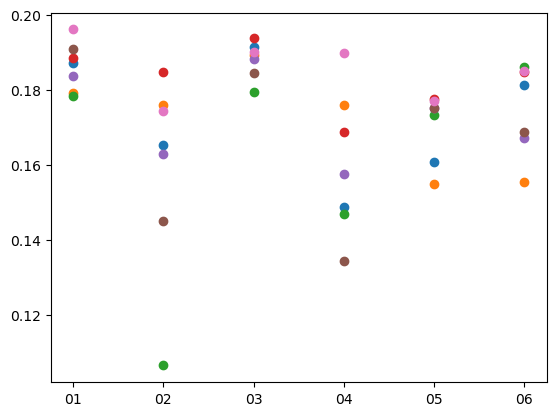

In [4]:
plt.plot(R2_i[:,:,8]/reps,'o')
plt.xticks(range(len(meshes)),meshes)

Text(0, 0.5, '$R^2$')

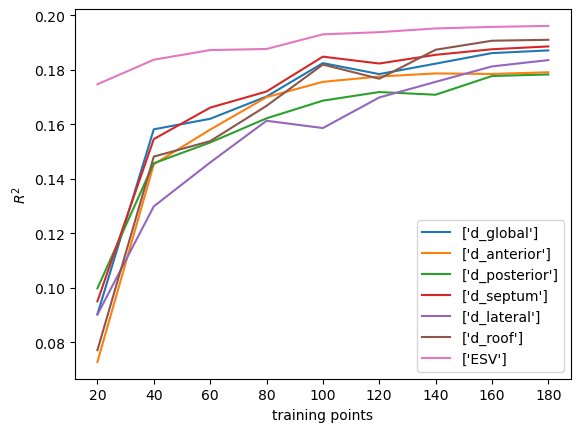

In [5]:
plt.plot(np.linspace(20,180,9),R2_i[0,:,:].T/reps)
plt.legend(y_labels.values)
plt.xlabel('training points')
plt.ylabel('$R^2$')

In [7]:
emulator.MSE(X_test,y_test)

tensor([ 0.3130,  0.3869,  0.2734,  0.7547,  0.4779,  0.5911, 38.5422],
       dtype=torch.float64, grad_fn=<MeanBackward1>)

In [8]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case01/xlabels.txt',delim_whitespace=True,header=None)

y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case01/ylabels.txt',delim_whitespace=True,header=None)


meshes=['01','02','03','04','05','06']

meshes.copy

t_size = 60
ts = 9
reps = 5
MSE_disc = np.zeros((len(meshes),len(meshes)-1,7,9))
R2_disc = np.zeros((len(meshes),len(meshes)-1,7,9))

for i in (range(len(meshes))):
    val0 = meshes[i]

    meshes2 = meshes.copy()
    meshes2.remove(meshes[i])

    inputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val0+"/X.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val0+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values

    X0 = torch.tensor(inputData_0)[0:200]
    Y0 = torch.tensor(outputData_0)[0:200]
    X0.columns = x_labels
    Y0.columns = y_labels
    emulator_0 = GPE.ensemble(X0,Y0,mean_func="linear",training_iter=500)

    for l in range(ts):
        t_size = 20*(l+1)

        for j in (range(len(meshes)-1)):
            val1 = meshes2[j]
            inputData_1 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val1+"/X.txt",index_col=None,delim_whitespace=True,header=None).values
            outputData_1 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val1+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values

            X1 = torch.tensor(inputData_1)[0:200]
            Y1 = torch.tensor(outputData_1)[0:200]
            X1.columns = x_labels
            Y1.columns = y_labels
            # split original dataset in training, validation and testing sets
            X_train, X_test, y_train, y_test = train_test_split(
                X1,
                Y1,
                test_size=0.1,
                random_state=seed
            )
            for k in range(reps):
                a=np.random.choice(range(X_train.shape[0]),t_size,replace=False)
                m0 = emulator_0.predict(X_train[a,:])
                y_adjust = torch.tensor(y_train[a] - m0)
                delta_1 = GPE.ensemble(X_train[a,:],y_adjust,mean_func="linear",training_iter=500)
                MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
                R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps



0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3495885928.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


In [9]:
y_labels

,0
0,d_global
1,d_anterior
2,d_posterior
3,d_septum
4,d_lateral
5,d_roof
6,ESV


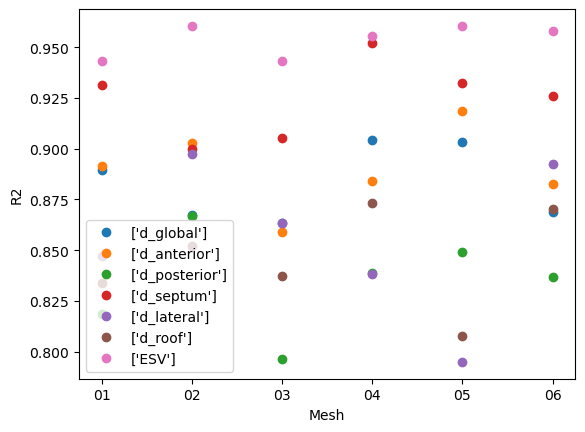

In [10]:
plt.plot(R2_disc[:,:,:,8].mean(axis=1),'o')
plt.xticks(range(len(meshes)),meshes)
plt.ylabel('R2')
plt.xlabel('Mesh')
plt.legend(y_labels.values)

In [11]:
np.linspace(20,180,9)

array([ 20.,  40.,  60.,  80., 100., 120., 140., 160., 180.])

In [12]:
R2_disc[:,:,0,:].mean(axis=1).shape

(6, 9)

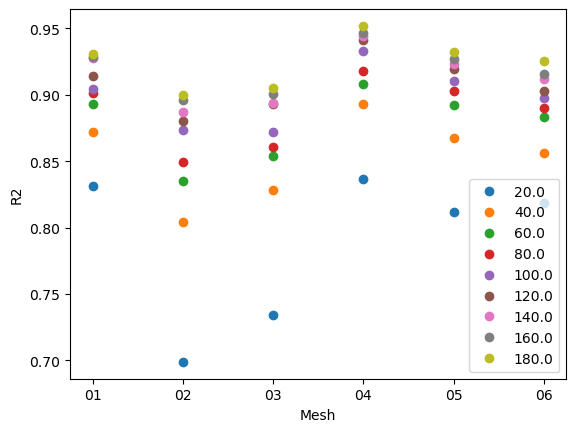

In [13]:
plt.plot(R2_disc[:,:,3,:].mean(axis=1),'o')
plt.xticks(range(len(meshes)),meshes)
plt.ylabel('R2')
plt.xlabel('Mesh')
plt.legend(np.linspace(20,180,9))

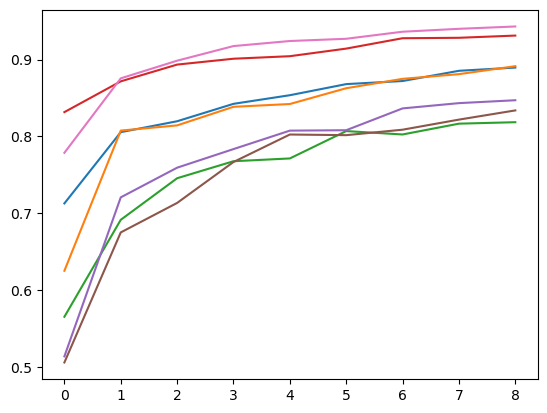

In [14]:
plt.plot(R2_disc[0,:,:,:].mean(axis=0).T)

In [15]:
inputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case01/X.txt",index_col=None,delim_whitespace=True,header=None).values
outputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case01/Y.txt",index_col=None,delim_whitespace=True,header=None).values

inputData_1 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case02/X.txt",index_col=None,delim_whitespace=True,header=None).values
outputData_1 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case02/Y.txt",index_col=None,delim_whitespace=True,header=None).values

X0 = torch.tensor(inputData_0)[0:200]
Y0 = torch.tensor(outputData_0)[0:200]

X1 = torch.tensor(inputData_1)[0:200]
Y1 = torch.tensor(outputData_1)[0:200]



emulator_0 = GPE.ensemble(X0,Y0,mean_func="constant",training_iter=0)

for param in emulator_0.models[0].named_parameters():
    print(f' value = {param}')

emulator_0 = GPE.ensemble(X0,Y0,mean_func="linear",training_iter=500)

for param in emulator_0.models[0].named_parameters():
    print(f' value = {param}')

# split original dataset in training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X1,
    Y1,
    test_size=0.1,
    random_state=seed
)

X_test.shape[1]

a=np.random.choice(range(X_train.shape[0]),18,replace=False)

X_train

X_train.shape

m0 = emulator_0.predict(X_train[a])

y_adjust = torch.tensor(y_train[a] - m0)

delta_1 = GPE.ensemble(X_train[a],y_adjust,mean_func="linear",training_iter=500)

np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())

1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-y_test)**2).mean(axis=0)/y_test.var(axis=0)



p = int(X1.shape[0]*0.05)
n = int(X_train.shape[0]/p)
reps = 5
MSE = np.zeros((n,reps,7))
R2 = np.zeros((n,reps,7))
MSE_p = np.zeros((n,reps,7))
R2_p = np.zeros((n,reps,7))
for i in range(n):
    for j in range(reps):
        a=np.random.choice(range(X_train.shape[0]),(i+1)*p,replace=False)
        m0 = emulator_0.predict(X_train[a,:])
        y_adjust = torch.tensor(y_train[a] - m0)
        delta_1 = GPE.ensemble(X_train[a,:],y_adjust,mean_func="linear",training_iter=500)
        MSE[i,j] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())
        R2[i,j] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-y_test)**2).mean(axis=0)/y_test.var(axis=0)).detach().numpy()
        
        delta_1p = GPE.ensemble(X_train[a,:],y_train[a],mean_func="linear",training_iter=500)
        MSE_p[i,j] += delta_1p.MSE(X_test,y_test).detach().numpy()
        R2_p[i,j] += delta_1p.R2(X_test,y_test).detach().numpy()

0
1
2
3
4
5
6
 value = ('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.], requires_grad=True))
 value = ('mean_module.raw_constant', Parameter containing:
tensor(0., requires_grad=True))
 value = ('covar_module.raw_outputscale', Parameter containing:
tensor(0., requires_grad=True))
 value = ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True))
0
1
2
3
4
5
6
 value = ('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-1.8245], requires_grad=True))
 value = ('mean_module.weights', Parameter containing:
tensor([[-0.6323],
        [ 0.0180],
        [-0.0515],
        [ 0.0835],
        [-0.1273],
        [-0.7567],
        [ 0.4297],
        [-0.0470],
        [-0.0719]], requires_grad=True))
 value = ('mean_module.bias', Parameter containing:
tensor([1.2614], requires_grad=True))
 value = ('covar_module.raw_outputscale', Parameter containing:
tensor(-0.1065, requires_grad

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3438816790.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3438816790.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3438816790.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3438816790.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE[i,j] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())


0
1
2
3
4
5
6


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:208: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_score=1-self.MSE(inputVals,outputVals)/torch.tensor(torch.var(outputVals,axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2


In [16]:
p

10

In [17]:
n

18

In [18]:
X_train.shape

torch.Size([180, 9])

In [19]:
x = np.linspace(20,180,18)

In [20]:
x

array([ 20.        ,  29.41176471,  38.82352941,  48.23529412,
        57.64705882,  67.05882353,  76.47058824,  85.88235294,
        95.29411765, 104.70588235, 114.11764706, 123.52941176,
       132.94117647, 142.35294118, 151.76470588, 161.17647059,
       170.58823529, 180.        ])

Text(0.5, 0, '$m$')

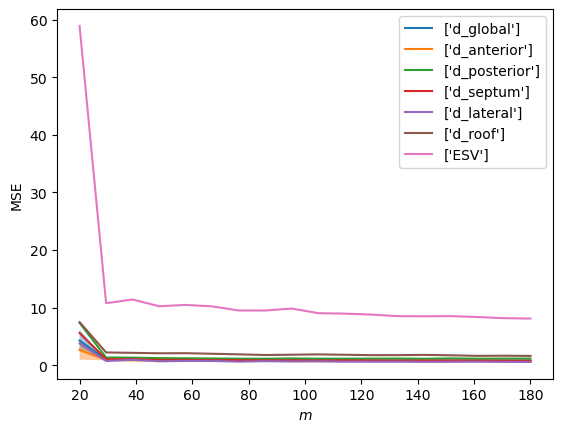

In [21]:
plt.plot(x,MSE.mean(axis=1))
plt.fill_between(x, MSE.mean(axis=1)[:,0]+MSE.std(axis=1)[:,0], y2=MSE.mean(axis=1)[:,0]-MSE.std(axis=1)[:,0],alpha=0.4)
plt.fill_between(x, MSE.mean(axis=1)[:,1]+MSE.std(axis=1)[:,1], y2=MSE.mean(axis=1)[:,1]-MSE.std(axis=1)[:,1],alpha=0.4)
plt.legend(y_labels.values)

plt.ylabel('MSE')
plt.xlabel('$m$')
#plt.yscale('log')


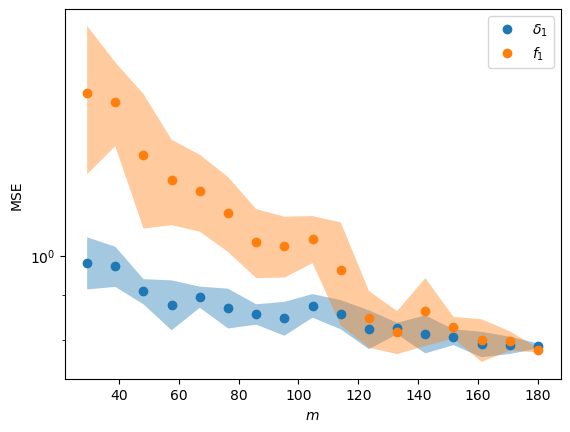

In [22]:
plt.plot(x[1:],np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1)))[1:,[0,7]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,0]+MSE.std(axis=1)[1:,0], y2=MSE.mean(axis=1)[1:,0]-MSE.std(axis=1)[1:,0],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,0]+MSE_p.std(axis=1)[1:,0], y2=MSE_p.mean(axis=1)[1:,0]-MSE_p.std(axis=1)[1:,0],alpha=0.4)
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

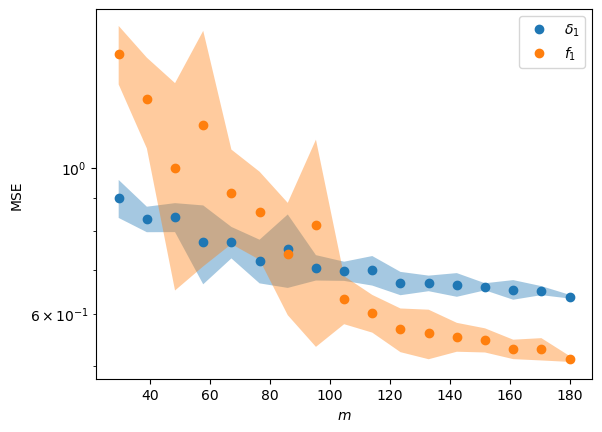

In [23]:
plt.plot(x[1:],np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1)))[1:,[1,8]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,1]+MSE.std(axis=1)[1:,1], y2=MSE.mean(axis=1)[1:,1]-MSE.std(axis=1)[1:,1],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,1]+MSE_p.std(axis=1)[1:,1], y2=MSE_p.mean(axis=1)[1:,1]-MSE_p.std(axis=1)[1:,1],alpha=0.4)
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

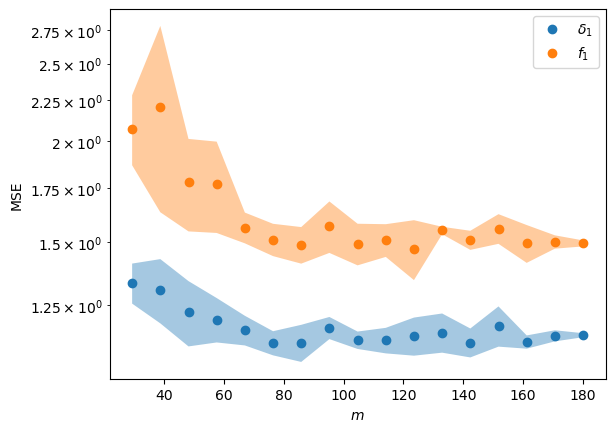

In [24]:
plt.plot(x[1:],np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1)))[1:,[2,9]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,2]+MSE.std(axis=1)[1:,2], y2=MSE.mean(axis=1)[1:,2]-MSE.std(axis=1)[1:,2],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,2]+MSE_p.std(axis=1)[1:,2], y2=MSE_p.mean(axis=1)[1:,2]-MSE_p.std(axis=1)[1:,2],alpha=0.4)
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

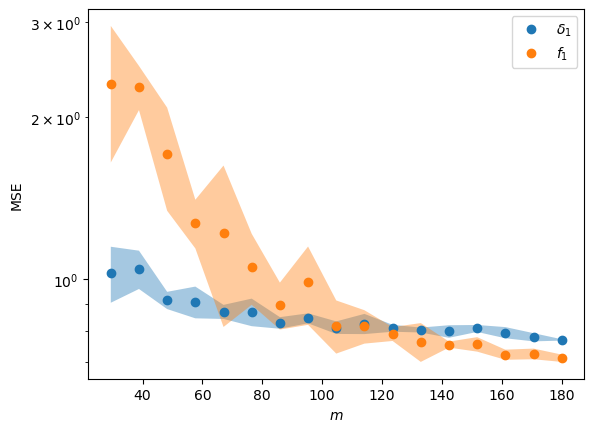

In [25]:
plt.plot(x[1:],np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1)))[1:,[3,10]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,3]+MSE.std(axis=1)[1:,3], y2=MSE.mean(axis=1)[1:,3]-MSE.std(axis=1)[1:,3],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,3]+MSE_p.std(axis=1)[1:,3], y2=MSE_p.mean(axis=1)[1:,3]-MSE_p.std(axis=1)[1:,3],alpha=0.4)
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

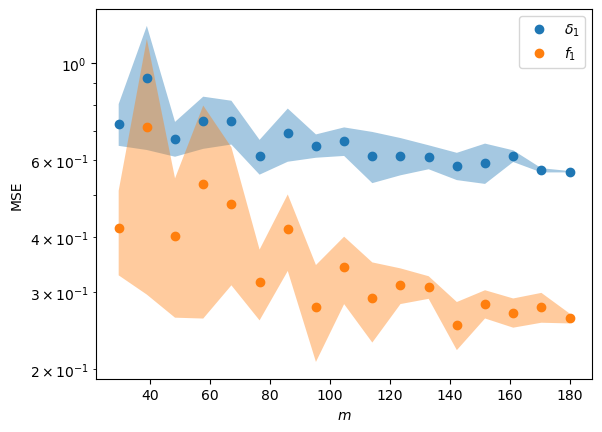

In [26]:
plt.plot(x[1:],np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1)))[1:,[4,11]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,4]+MSE.std(axis=1)[1:,4], y2=MSE.mean(axis=1)[1:,4]-MSE.std(axis=1)[1:,4],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,4]+MSE_p.std(axis=1)[1:,4], y2=MSE_p.mean(axis=1)[1:,4]-MSE_p.std(axis=1)[1:,4],alpha=0.4)
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

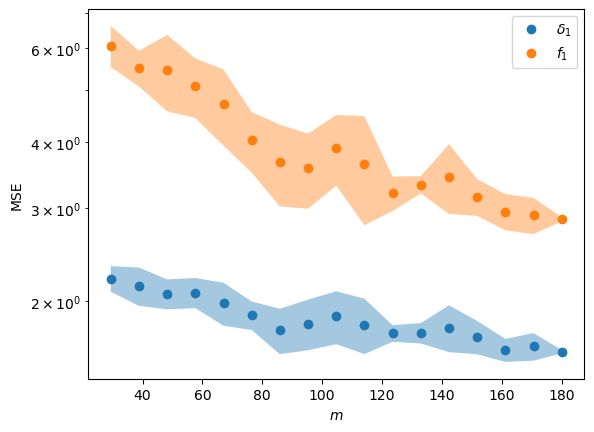

In [27]:
plt.plot(x[1:],np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1)))[1:,[5,12]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,5]+MSE.std(axis=1)[1:,5], y2=MSE.mean(axis=1)[1:,5]-MSE.std(axis=1)[1:,5],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,5]+MSE_p.std(axis=1)[1:,5], y2=MSE_p.mean(axis=1)[1:,5]-MSE_p.std(axis=1)[1:,5],alpha=0.4)
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

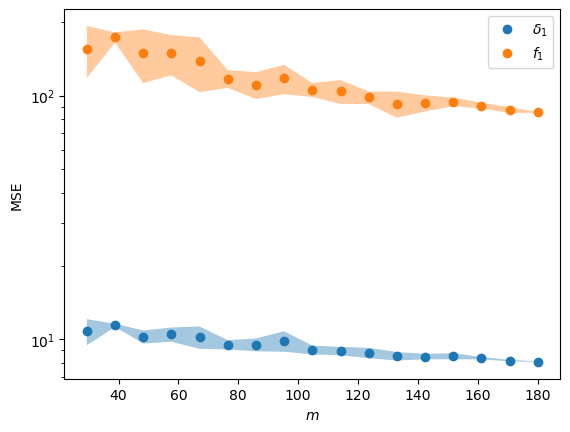

In [28]:
plt.plot(x[1:],np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1)))[1:,[6,13]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,6]+MSE.std(axis=1)[1:,6], y2=MSE.mean(axis=1)[1:,6]-MSE.std(axis=1)[1:,6],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,6]+MSE_p.std(axis=1)[1:,6], y2=MSE_p.mean(axis=1)[1:,6]-MSE_p.std(axis=1)[1:,6],alpha=0.4)
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

In [29]:
#b=np.random.choice(range(X_train.shape[0]),18,replace=False)
p = int(X0.shape[0]*0.05)
n = int(X0.shape[0]/p)
m = 18
MSE_mn = np.zeros((n,m,7))
R2_mn = np.zeros((n,m,7))
reps = 5
for i in range(n):
    for k in range(m):
        for j in range(reps):
            b=np.random.choice(range(X_train.shape[0]),(k+1)*p,replace=False)
            a=np.random.choice(range(X0.shape[0]),(i+1)*p,replace=False)
            emulator_0 = GPE.ensemble(X0[a,:],Y0[a,:],mean_func="linear",training_iter=500)
            m0 = emulator_0.predict(X_train[b,:])
            y_adjust = torch.tensor(y_train[b] - m0)
            delta_1 = GPE.ensemble(X_train[b,:],y_adjust,mean_func="linear",training_iter=500)
            MSE_mn[i,k] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
            R2_mn[i,k] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/1110072799.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[b] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/1110072799.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_mn[i,k] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/1110072799.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mn[i,k] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2


2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4


4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1


1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3


3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5


5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0


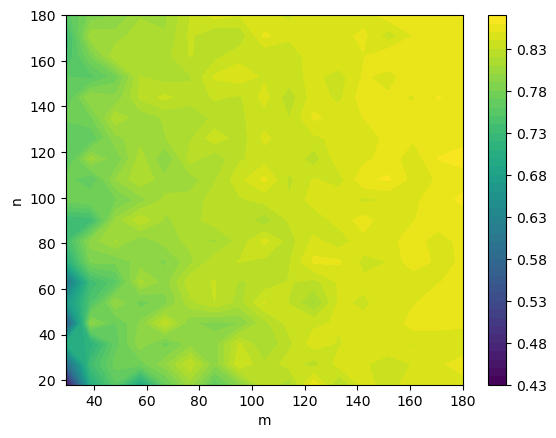

In [30]:
x

y = np.linspace(9,180,20)

y

xx,yy=np.meshgrid(x,y)

xx[1:,1:].shape

level = 1

plt.contourf(xx[level:,level:],yy[level:,level:],R2_mn[level:,level:,0],origin='lower',levels=50)
plt.ylabel('n')
plt.xlabel('m')
plt.colorbar()

In [31]:
import scipy

In [32]:
def proxy(a,y_train,m0,output):
    a=torch.tensor(a)
    res = ((a*m0-y_train)**2).mean(axis=1).detach().numpy()
    return res[output]

In [33]:
#b=np.random.choice(range(X_train.shape[0]),18,replace=False)
p = int(X0.shape[0]*0.05)
n = int(X0.shape[0]/p)
m = 18
MSE_a = np.zeros((n,m,7))
R2_a = np.zeros((n,m,7))
reps = 5
for i in range(n):
    for k in range(m):
        for j in range(reps):
            b=np.random.choice(range(X_train.shape[0]),(k+1)*p,replace=False)
            a=np.random.choice(range(X0.shape[0]),(i+1)*p,replace=False)
            
            emulator_0 = GPE.ensemble(X0[a,:],Y0[a,:],mean_func="linear",training_iter=500)
            m0 = emulator_0.predict(X_train[b,:])
            
            a_d=np.zeros(y_train.shape[1])
            for l in range(y_train.shape[1]):
                result = scipy.optimize.minimize(proxy, 1, args=(y_train[b,:],m0,l), method='Nelder-Mead', tol=1e-8)
                print(result.x)
                a_d[l]=result.x

            a_d=torch.tensor(a_d)
            print(a_d)
            
            
            y_adjust = torch.tensor(y_train[b] - a_d*m0)
            delta_1 = GPE.ensemble(X_train[b,:],y_adjust,mean_func="linear",training_iter=500)
            MSE_a[i,k] += np.sqrt(((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
            R2_a[i,k] += (1-((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
[1.94849362]
[1.86849791]
[2.06302633]
[2.01391448]
[1.951214]
[2.03817778]
[1.98946034]
tensor([1.9485, 1.8685, 2.0630, 2.0139, 1.9512, 2.0382, 1.9895],
       dtype=torch.float64)
0


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3734071795.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[b] - a_d*m0)


1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3734071795.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_a[i,k] += np.sqrt(((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_80698/3734071795.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_a[i,k] += (1-((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
[1.6333407]
[1.95161565]
[1.85690151]
[1.80652923]
[2.11987943]
[2.11527699]
[1.87578329]
tensor([1.6333, 1.9516, 1.8569, 1.8065, 2.1199, 2.1153, 1.8758],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.71109401]
[1.65325838]
[1.48367007]
[2.15585139]
[1.67386339]
[1.85033513]
[1.89120167]
tensor([1.7111, 1.6533, 1.4837, 2.1559, 1.6739, 1.8503, 1.8912],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.9278205]
[1.63857024]
[2.03488785]
[1.82290457]
[1.76075296]
[1.69335959]
[1.87813713]
tensor([1.9278, 1.6386, 2.0349, 1.8229, 1.7608, 1.6934, 1.8781],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.76872913]
[1.82964626]
[1.90278219]
[1.82648107]
[1.92118367]
[1.82942708]
[1.7664799]
tensor([1.7687, 1.8296, 1.9028, 1.8265, 1.9212, 1.8294, 1.7665],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.79817707]
[2.48228205]
[0.95495942]
[-0.75051075]
[2.23370592]
[1.28216465]
[2.27724737]
tensor([ 1.7982,  2.4823,  0.9550, -0.7505,  2.23

1
2
3
4
5
6
0
1
2
3
4
5
6
[2.24406877]
[1.90602301]
[3.11334953]
[2.74972851]
[2.24406705]
[3.1079719]
[2.24763439]
tensor([2.2441, 1.9060, 3.1133, 2.7497, 2.2441, 3.1080, 2.2476],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[2.06689711]
[1.90882535]
[1.72883484]
[2.02393171]
[1.74600008]
[1.82606517]
[1.80759048]
tensor([2.0669, 1.9088, 1.7288, 2.0239, 1.7460, 1.8261, 1.8076],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.89896133]
[2.02208695]
[1.88543708]
[1.9203021]
[2.01186383]
[2.05320069]
[1.72755156]
tensor([1.8990, 2.0221, 1.8854, 1.9203, 2.0119, 2.0532, 1.7276],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.81500362]
[1.59777787]
[1.81582255]
[1.83411427]
[1.85914131]
[1.64363222]
[1.71469231]
tensor([1.8150, 1.5978, 1.8158, 1.8341, 1.8591, 1.6436, 1.7147],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[2.67772429]
[1.97879149]
[3.41951436]
[2.9373727]
[2.24102548]
[1.49552132]
[1.85173925]
tensor([2.6777, 1.9788, 3.4195, 2.9374

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.68945468]
[2.06362156]
[2.00928198]
[1.56115112]
[1.81646019]
[1.66704395]
[1.52750958]
tensor([1.6895, 2.0636, 2.0093, 1.5612, 1.8165, 1.6670, 1.5275],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.82539444]
[1.88731472]
[1.77762802]
[1.92777153]
[1.87379789]
[1.76488193]
[1.7902706]
tensor([1.8254, 1.8873, 1.7776, 1.9278, 1.8738, 1.7649, 1.7903],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.40812141]
[1.77294042]
[1.23377412]
[1.37601544]
[1.51182231]
[3.00211371]
[1.34403441]
tensor([1.4081, 1.7729, 1.2338, 1.3760, 1.5118, 3.0021, 1.3440],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.56713682]
[1.620003]
[1.8025138]
[1.53091483]
[1.9450743]
[1.63107999]
[1.71737266]
tensor([1.5671, 1.6200, 1.8025, 1.5309, 1.9451, 1.6311, 1.7174],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.34818993]
[4.10635804]
[1.75037987]
[2.0391709]
[1.3612556]
[1.28605136]
[1.61689658]
tensor([1.3482, 4.1064, 1.7504, 2.0392, 1.

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.93554658]
[1.90147166]
[1.71572366]
[1.69590731]
[1.95615707]
[1.82067506]
[2.04718679]
tensor([1.9355, 1.9015, 1.7157, 1.6959, 1.9562, 1.8207, 2.0472],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.75585728]
[1.68894334]
[1.75875503]
[1.81665397]
[1.80828227]
[2.01415967]
[1.90316787]
tensor([1.7559, 1.6889, 1.7588, 1.8167, 1.8083, 2.0142, 1.9032],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.95956498]
[1.93532851]
[1.68663445]
[1.98579798]
[1.87220237]
[1.80598196]
[2.05886172]
tensor([1.9596, 1.9353, 1.6866, 1.9858, 1.8722, 1.8060, 2.0589],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.74525462]
[1.87919626]
[1.7932669]
[1.84914767]
[1.76755304]
[1.87878944]
[1.95935348]
tensor([1.7453, 1.8792, 1.7933, 1.8491, 1.7676, 1.8788, 1.9594],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.85391741]
[1.80268506]
[1.69392111]
[1.76093312]
[2.15432528]
[1.90285978]
[1.85517634]
tensor([1.8539, 1.8027, 1.6939, 1.76

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.73399924]
[1.77746829]
[2.11947445]
[2.12778633]
[1.74530278]
[1.7360344]
[1.73491044]
tensor([1.7340, 1.7775, 2.1195, 2.1278, 1.7453, 1.7360, 1.7349],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.78815318]
[1.82078699]
[1.76905361]
[1.83979051]
[1.93747425]
[1.75327035]
[1.78273304]
tensor([1.7882, 1.8208, 1.7691, 1.8398, 1.9375, 1.7533, 1.7827],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.62189963]
[1.74333423]
[1.70930805]
[1.98322331]
[1.90104974]
[1.75583972]
[1.69150598]
tensor([1.6219, 1.7433, 1.7093, 1.9832, 1.9010, 1.7558, 1.6915],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.95643027]
[1.61829291]
[1.64510823]
[2.08560464]
[1.63886123]
[2.03141376]
[1.87805502]
tensor([1.9564, 1.6183, 1.6451, 2.0856, 1.6389, 2.0314, 1.8781],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.88533223]
[1.78689282]
[1.91049329]
[1.8383284]
[1.96064703]
[2.10499617]
[1.86887023]
tensor([1.8853, 1.7869, 1.9105, 1.838

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.88760921]
[1.78934699]
[2.07276933]
[1.80627201]
[1.74564846]
[1.82115117]
[1.84027658]
tensor([1.8876, 1.7893, 2.0728, 1.8063, 1.7456, 1.8212, 1.8403],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.76495832]
[1.73132752]
[1.96749212]
[1.95073258]
[1.86251891]
[1.7873341]
[2.10178241]
tensor([1.7650, 1.7313, 1.9675, 1.9507, 1.8625, 1.7873, 2.1018],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.88107004]
[1.80337084]
[1.70982504]
[1.84175337]
[1.83215367]
[1.87433289]
[1.81561251]
tensor([1.8811, 1.8034, 1.7098, 1.8418, 1.8322, 1.8743, 1.8156],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.80732919]
[1.89942456]
[1.80216877]
[1.70588833]
[1.77489578]
[2.01889874]
[1.80668827]
tensor([1.8073, 1.8994, 1.8022, 1.7059, 1.7749, 2.0189, 1.8067],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[2.15598511]
[1.83312746]
[2.04626972]
[1.8276753]
[1.82546588]
[2.02924976]
[1.83898668]
tensor([2.1560, 1.8331, 2.0463, 1.827

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.88005614]
[1.739835]
[1.76405389]
[1.93765293]
[1.76142142]
[1.97094818]
[1.85326185]
tensor([1.8801, 1.7398, 1.7641, 1.9377, 1.7614, 1.9709, 1.8533],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.88407424]
[1.75555556]
[1.88449243]
[1.72072741]
[1.97433876]
[1.89734362]
[1.8948625]
tensor([1.8841, 1.7556, 1.8845, 1.7207, 1.9743, 1.8973, 1.8949],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.75088987]
[1.92758448]
[1.82025778]
[1.7764516]
[1.7501707]
[1.91082416]
[1.78934486]
tensor([1.7509, 1.9276, 1.8203, 1.7765, 1.7502, 1.9108, 1.7893],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.77021793]
[1.78722214]
[1.84222506]
[1.70730724]
[1.7320964]
[1.85741405]
[1.81840587]
tensor([1.7702, 1.7872, 1.8422, 1.7073, 1.7321, 1.8574, 1.8184],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.72316141]
[1.84863638]
[1.86896318]
[1.7503047]
[1.90766711]
[1.76984997]
[2.17016443]
tensor([1.7232, 1.8486, 1.8690, 1.7503, 1.

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.888051]
[1.77504424]
[1.8293211]
[1.84137899]
[1.75090696]
[1.76587917]
[1.74695109]
tensor([1.8881, 1.7750, 1.8293, 1.8414, 1.7509, 1.7659, 1.7470],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.82700488]
[1.99588791]
[1.79825945]
[1.83133944]
[1.8308877]
[1.86099188]
[1.99569047]
tensor([1.8270, 1.9959, 1.7983, 1.8313, 1.8309, 1.8610, 1.9957],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.76162514]
[2.03239771]
[1.76847441]
[1.87710722]
[1.7469743]
[1.79868184]
[1.94314424]
tensor([1.7616, 2.0324, 1.7685, 1.8771, 1.7470, 1.7987, 1.9431],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.79551639]
[1.88620383]
[1.91087638]
[1.81281881]
[1.78771876]
[1.77679721]
[1.84267833]
tensor([1.7955, 1.8862, 1.9109, 1.8128, 1.7877, 1.7768, 1.8427],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.85948733]
[1.88754578]
[2.00945203]
[1.81988362]
[1.81425718]
[1.73879268]
[1.852124]
tensor([1.8595, 1.8875, 2.0095, 1.8199, 1.

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.76989896]
[1.70186503]
[1.87842966]
[1.95732991]
[1.82684268]
[1.84482352]
[1.87446503]
tensor([1.7699, 1.7019, 1.8784, 1.9573, 1.8268, 1.8448, 1.8745],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.85911122]
[1.73164774]
[1.69120787]
[1.77627448]
[1.88958231]
[1.77044044]
[1.91316644]
tensor([1.8591, 1.7316, 1.6912, 1.7763, 1.8896, 1.7704, 1.9132],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.77440767]
[1.76719846]
[1.87841489]
[1.79916343]
[1.6945176]
[1.94578186]
[1.84895381]
tensor([1.7744, 1.7672, 1.8784, 1.7992, 1.6945, 1.9458, 1.8490],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.85180296]
[1.8977212]
[1.78788074]
[1.98985547]
[1.79224484]
[1.73207805]
[1.66959397]
tensor([1.8518, 1.8977, 1.7879, 1.9899, 1.7922, 1.7321, 1.6696],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.88884758]
[1.81623434]
[1.79634853]
[1.87431461]
[1.85593815]
[1.7914369]
[1.84038848]
tensor([1.8888, 1.8162, 1.7963, 1.8743

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.77337554]
[1.87658973]
[1.82466203]
[1.75073744]
[1.76279355]
[1.70202569]
[1.86120093]
tensor([1.7734, 1.8766, 1.8247, 1.7507, 1.7628, 1.7020, 1.8612],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.80903112]
[1.77061391]
[1.7974571]
[1.84362821]
[1.75088895]
[1.74306158]
[1.82239241]
tensor([1.8090, 1.7706, 1.7975, 1.8436, 1.7509, 1.7431, 1.8224],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.93723119]
[1.83576173]
[1.80166782]
[1.77286097]
[1.84352998]
[1.80549586]
[1.7977218]
tensor([1.9372, 1.8358, 1.8017, 1.7729, 1.8435, 1.8055, 1.7977],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.83141779]
[1.88226172]
[1.94141545]
[1.67676228]
[1.88197497]
[1.84600089]
[1.92869548]
tensor([1.8314, 1.8823, 1.9414, 1.6768, 1.8820, 1.8460, 1.9287],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.76084428]
[1.84877086]
[1.84215608]
[1.78220549]
[1.84741676]
[1.88634838]
[1.92569618]
tensor([1.7608, 1.8488, 1.8422, 1.782

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.81887094]
[1.88515592]
[1.82861637]
[1.88692251]
[1.81294439]
[1.79158275]
[1.69681849]
tensor([1.8189, 1.8852, 1.8286, 1.8869, 1.8129, 1.7916, 1.6968],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.95436405]
[1.99583368]
[1.82136815]
[1.87606667]
[1.8111468]
[1.8728551]
[1.74319353]
tensor([1.9544, 1.9958, 1.8214, 1.8761, 1.8111, 1.8729, 1.7432],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.87836253]
[1.81306022]
[1.81478592]
[1.74919392]
[1.84327209]
[2.0198773]
[1.79618979]
tensor([1.8784, 1.8131, 1.8148, 1.7492, 1.8433, 2.0199, 1.7962],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.82455346]
[1.72602308]
[1.95094709]
[1.82211477]
[1.95094585]
[1.87946897]
[1.80880122]
tensor([1.8246, 1.7260, 1.9509, 1.8221, 1.9509, 1.8795, 1.8088],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.89296836]
[1.76322201]
[1.75943668]
[1.74440772]
[1.76633931]
[1.8657525]
[1.72852007]
tensor([1.8930, 1.7632, 1.7594, 1.7444,

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.85016413]
[1.78548481]
[1.82996656]
[1.94005436]
[1.85630671]
[1.82193038]
[1.78185682]
tensor([1.8502, 1.7855, 1.8300, 1.9401, 1.8563, 1.8219, 1.7819],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.8319685]
[1.88165532]
[1.76826653]
[1.72609961]
[1.83467619]
[1.7886517]
[1.91684877]
tensor([1.8320, 1.8817, 1.7683, 1.7261, 1.8347, 1.7887, 1.9168],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.78862216]
[1.74269232]
[1.94736737]
[1.87764429]
[1.86567757]
[2.00054656]
[1.89317544]
tensor([1.7886, 1.7427, 1.9474, 1.8776, 1.8657, 2.0005, 1.8932],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.82054654]
[1.76666852]
[1.74204324]
[1.78571674]
[1.87510343]
[1.79179492]
[1.86033424]
tensor([1.8205, 1.7667, 1.7420, 1.7857, 1.8751, 1.7918, 1.8603],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.70850325]
[1.86762491]
[1.85051081]
[1.81761056]
[1.94042763]
[1.75084526]
[1.88615636]
tensor([1.7085, 1.8676, 1.8505, 1.817

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.79804201]
[1.86338699]
[1.78792036]
[1.93671529]
[1.74158845]
[1.77357357]
[1.72156324]
tensor([1.7980, 1.8634, 1.7879, 1.9367, 1.7416, 1.7736, 1.7216],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[2.04000678]
[1.94713013]
[1.88171362]
[1.95432376]
[1.9286175]
[1.79253882]
[1.89281476]
tensor([2.0400, 1.9471, 1.8817, 1.9543, 1.9286, 1.7925, 1.8928],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.857866]
[1.87619907]
[1.71226121]
[1.91828014]
[1.85039984]
[1.80237857]
[1.83650963]
tensor([1.8579, 1.8762, 1.7123, 1.9183, 1.8504, 1.8024, 1.8365],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.83439471]
[1.80782251]
[1.82824729]
[1.87687763]
[1.8838852]
[2.03321359]
[1.85628499]
tensor([1.8344, 1.8078, 1.8282, 1.8769, 1.8839, 2.0332, 1.8563],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.83608273]
[1.76121004]
[1.83106865]
[1.81986574]
[1.84834509]
[1.81641502]
[1.75910954]
tensor([1.8361, 1.7612, 1.8311, 1.8199,

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.74239752]
[1.8232213]
[2.01646709]
[1.76655253]
[1.81977781]
[1.80907766]
[1.8747203]
tensor([1.7424, 1.8232, 2.0165, 1.7666, 1.8198, 1.8091, 1.8747],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.9467357]
[1.85091235]
[1.89374318]
[1.84017]
[1.96130119]
[1.68354962]
[1.93579639]
tensor([1.9467, 1.8509, 1.8937, 1.8402, 1.9613, 1.6835, 1.9358],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.80023491]
[1.82554988]
[1.83180882]
[1.88061087]
[1.91149341]
[1.77591925]
[1.88597055]
tensor([1.8002, 1.8255, 1.8318, 1.8806, 1.9115, 1.7759, 1.8860],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.77783747]
[1.84266214]
[1.82595528]
[1.8648386]
[2.13333045]
[1.77161889]
[1.85328148]
tensor([1.7778, 1.8427, 1.8260, 1.8648, 2.1333, 1.7716, 1.8533],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[2.10895488]
[1.8249419]
[1.8374759]
[1.76796574]
[1.89443167]
[1.81251892]
[1.80872469]
tensor([2.1090, 1.8249, 1.8375, 1.7680, 1.89

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.81598366]
[1.77665861]
[1.83371251]
[1.78412732]
[1.85772843]
[1.7598188]
[2.00818147]
tensor([1.8160, 1.7767, 1.8337, 1.7841, 1.8577, 1.7598, 2.0082],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.85376083]
[1.77753267]
[1.81719488]
[1.83195195]
[1.817512]
[1.85848077]
[1.7569002]
tensor([1.8538, 1.7775, 1.8172, 1.8320, 1.8175, 1.8585, 1.7569],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.79261172]
[1.74059806]
[1.85277063]
[1.83279645]
[1.86801734]
[1.88990285]
[1.78497694]
tensor([1.7926, 1.7406, 1.8528, 1.8328, 1.8680, 1.8899, 1.7850],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.91228046]
[1.80325319]
[1.841672]
[1.84816846]
[1.856901]
[1.93783454]
[1.82717474]
tensor([1.9123, 1.8033, 1.8417, 1.8482, 1.8569, 1.9378, 1.8272],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.86650881]
[1.76883966]
[1.91228738]
[1.9335961]
[1.85108014]
[1.74147776]
[1.80977113]
tensor([1.8665, 1.7688, 1.9123, 1.9336, 1.85

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.80933414]
[2.03379595]
[1.93318624]
[1.82256655]
[1.95367973]
[1.85806152]
[1.80963598]
tensor([1.8093, 2.0338, 1.9332, 1.8226, 1.9537, 1.8581, 1.8096],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.83768855]
[1.80475915]
[1.92330683]
[1.75866243]
[1.76639849]
[1.90303476]
[1.84266988]
tensor([1.8377, 1.8048, 1.9233, 1.7587, 1.7664, 1.9030, 1.8427],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.89449338]
[1.82002265]
[1.80630156]
[1.92899637]
[1.83261806]
[1.90076299]
[2.06492348]
tensor([1.8945, 1.8200, 1.8063, 1.9290, 1.8326, 1.9008, 2.0649],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.86590376]
[1.82314252]
[1.71550638]
[1.81152675]
[1.76690239]
[1.95589893]
[1.93053927]
tensor([1.8659, 1.8231, 1.7155, 1.8115, 1.7669, 1.9559, 1.9305],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.88224479]
[1.77232758]
[1.77468149]
[1.94346231]
[1.85247721]
[1.88727147]
[1.76537992]
tensor([1.8822, 1.7723, 1.7747, 1.9

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.92046738]
[1.7836614]
[1.83658869]
[1.84003657]
[1.79797961]
[1.88518919]
[1.76515982]
tensor([1.9205, 1.7837, 1.8366, 1.8400, 1.7980, 1.8852, 1.7652],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.81077755]
[1.85724298]
[1.77928065]
[1.82401701]
[1.9152808]
[1.84935965]
[1.84565188]
tensor([1.8108, 1.8572, 1.7793, 1.8240, 1.9153, 1.8494, 1.8457],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.94016851]
[1.83114375]
[1.74731436]
[1.82951627]
[1.71036306]
[1.98647946]
[1.85736151]
tensor([1.9402, 1.8311, 1.7473, 1.8295, 1.7104, 1.9865, 1.8574],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.85808086]
[1.7999503]
[1.83190873]
[2.02520395]
[1.78402702]
[1.82823781]
[1.77377545]
tensor([1.8581, 1.8000, 1.8319, 2.0252, 1.7840, 1.8282, 1.7738],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.75107797]
[2.01669788]
[1.80411288]
[1.83486442]
[1.83613509]
[1.83907452]
[1.87841538]
tensor([1.7511, 2.0167, 1.8041, 1.8349

1
2
3
4
5
6
0
1
2
3
4
5
6
[2.02410936]
[1.80013769]
[1.82275093]
[1.87740291]
[1.88056632]
[1.90355465]
[1.87290414]
tensor([2.0241, 1.8001, 1.8228, 1.8774, 1.8806, 1.9036, 1.8729],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.88941678]
[1.88300062]
[1.77737619]
[1.70827659]
[1.94201685]
[1.85915141]
[1.73193066]
tensor([1.8894, 1.8830, 1.7774, 1.7083, 1.9420, 1.8592, 1.7319],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.92383594]
[1.82721587]
[1.73467957]
[1.7925043]
[1.97880954]
[1.96220756]
[2.01405538]
tensor([1.9238, 1.8272, 1.7347, 1.7925, 1.9788, 1.9622, 2.0141],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.8579884]
[1.82338211]
[1.85017275]
[1.72320368]
[1.76942537]
[1.8616058]
[1.85578873]
tensor([1.8580, 1.8234, 1.8502, 1.7232, 1.7694, 1.8616, 1.8558],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.8996986]
[1.91558709]
[1.88768498]
[1.8065491]
[1.76492103]
[1.81895491]
[1.70316674]
tensor([1.8997, 1.9156, 1.8877, 1.8065, 

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.98056241]
[1.88167448]
[1.87031446]
[1.71113722]
[1.9816291]
[1.78197328]
[1.81920778]
tensor([1.9806, 1.8817, 1.8703, 1.7111, 1.9816, 1.7820, 1.8192],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.99499255]
[1.87599643]
[1.77623038]
[1.84329197]
[1.72792614]
[1.93443296]
[1.86984997]
tensor([1.9950, 1.8760, 1.7762, 1.8433, 1.7279, 1.9344, 1.8698],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.71619873]
[1.81718013]
[1.82621452]
[1.88575324]
[1.80984792]
[1.84061784]
[1.89208763]
tensor([1.7162, 1.8172, 1.8262, 1.8858, 1.8098, 1.8406, 1.8921],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.85837631]
[1.74662737]
[1.90954725]
[1.73066123]
[1.82411336]
[1.83297842]
[1.7911775]
tensor([1.8584, 1.7466, 1.9095, 1.7307, 1.8241, 1.8330, 1.7912],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.82015215]
[1.99805693]
[1.84014072]
[1.76950253]
[1.84525415]
[1.79495241]
[1.85054716]
tensor([1.8202, 1.9981, 1.8401, 1.769

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.84715862]
[1.83214101]
[1.86321201]
[1.70765215]
[1.79691934]
[1.81750219]
[1.89671551]
tensor([1.8472, 1.8321, 1.8632, 1.7077, 1.7969, 1.8175, 1.8967],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.81076574]
[1.7241773]
[1.79614171]
[1.86073284]
[1.7978869]
[1.83695835]
[1.8349121]
tensor([1.8108, 1.7242, 1.7961, 1.8607, 1.7979, 1.8370, 1.8349],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.80859111]
[1.85269647]
[1.81880765]
[1.97191226]
[1.77718151]
[1.80040409]
[1.82431581]
tensor([1.8086, 1.8527, 1.8188, 1.9719, 1.7772, 1.8004, 1.8243],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.75066739]
[1.83527702]
[1.82659686]
[1.80787826]
[1.8088171]
[1.90388298]
[1.81723204]
tensor([1.7507, 1.8353, 1.8266, 1.8079, 1.8088, 1.9039, 1.8172],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.95271131]
[1.80869979]
[1.87988464]
[1.87170855]
[1.85044656]
[1.78581161]
[1.82831795]
tensor([1.9527, 1.8087, 1.8799, 1.8717,

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.91999398]
[1.77663865]
[1.65699079]
[1.8921684]
[1.85634521]
[1.7893191]
[1.74207774]
tensor([1.9200, 1.7766, 1.6570, 1.8922, 1.8563, 1.7893, 1.7421],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.84764578]
[1.8465955]
[1.8190777]
[1.84796496]
[1.85152785]
[1.85609952]
[1.84608941]
tensor([1.8476, 1.8466, 1.8191, 1.8480, 1.8515, 1.8561, 1.8461],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.8199056]
[1.71645344]
[1.81786044]
[1.84136268]
[1.85946379]
[1.8336005]
[1.84038546]
tensor([1.8199, 1.7165, 1.8179, 1.8414, 1.8595, 1.8336, 1.8404],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.82972453]
[1.76498854]
[1.75798613]
[1.82065505]
[1.82488822]
[1.7984646]
[1.84387723]
tensor([1.8297, 1.7650, 1.7580, 1.8207, 1.8249, 1.7985, 1.8439],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.82012547]
[1.78364326]
[1.77433512]
[1.84727458]
[1.81814175]
[1.99605109]
[1.818298]
tensor([1.8201, 1.7836, 1.7743, 1.8473, 1.81

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.84491485]
[1.9089339]
[1.85391556]
[1.93045977]
[1.86616524]
[1.69208784]
[1.82114457]
tensor([1.8449, 1.9089, 1.8539, 1.9305, 1.8662, 1.6921, 1.8211],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.86106458]
[1.76824148]
[1.86527115]
[1.84333452]
[1.72263516]
[1.93339036]
[1.91705055]
tensor([1.8611, 1.7682, 1.8653, 1.8433, 1.7226, 1.9334, 1.9171],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.79962776]
[1.77310717]
[1.83912959]
[2.02762033]
[1.91672504]
[1.8173253]
[1.85540209]
tensor([1.7996, 1.7731, 1.8391, 2.0276, 1.9167, 1.8173, 1.8554],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.70737027]
[1.72983612]
[1.808099]
[1.77163057]
[1.9450577]
[1.82536106]
[1.77309728]
tensor([1.7074, 1.7298, 1.8081, 1.7716, 1.9451, 1.8254, 1.7731],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.8061362]
[1.84027952]
[1.77005662]
[1.84983006]
[1.8064713]
[1.81921307]
[1.87474547]
tensor([1.8061, 1.8403, 1.7701, 1.8498, 1.

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.86870918]
[1.86278074]
[1.91766277]
[1.77988324]
[1.79698739]
[1.8215648]
[1.89776056]
tensor([1.8687, 1.8628, 1.9177, 1.7799, 1.7970, 1.8216, 1.8978],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.82312086]
[1.76346663]
[1.9500384]
[1.79081486]
[1.82494851]
[1.81774389]
[1.80891368]
tensor([1.8231, 1.7635, 1.9500, 1.7908, 1.8249, 1.8177, 1.8089],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.75843318]
[1.84034582]
[1.75259999]
[1.75407636]
[1.77238036]
[1.69124539]
[1.91339883]
tensor([1.7584, 1.8403, 1.7526, 1.7541, 1.7724, 1.6912, 1.9134],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.75835182]
[1.79376162]
[1.87276378]
[1.82558892]
[1.91764472]
[1.76612777]
[1.76123889]
tensor([1.7584, 1.7938, 1.8728, 1.8256, 1.9176, 1.7661, 1.7612],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.83329524]
[1.81721991]
[1.76953872]
[1.78434334]
[1.8569359]
[1.96944836]
[1.84682684]
tensor([1.8333, 1.8172, 1.7695, 1.7843

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.77654855]
[2.07624086]
[1.82040272]
[1.83827636]
[1.74236565]
[1.88738863]
[1.92640322]
tensor([1.7765, 2.0762, 1.8204, 1.8383, 1.7424, 1.8874, 1.9264],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.82972066]
[1.76562927]
[1.79063154]
[1.81277373]
[1.81501243]
[1.80013936]
[1.85359174]
tensor([1.8297, 1.7656, 1.7906, 1.8128, 1.8150, 1.8001, 1.8536],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.91196962]
[1.86687495]
[1.90827425]
[1.81746926]
[1.85303863]
[1.71052896]
[1.84514089]
tensor([1.9120, 1.8669, 1.9083, 1.8175, 1.8530, 1.7105, 1.8451],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.86594149]
[1.85415715]
[1.7872812]
[1.77469956]
[1.78564981]
[1.81775548]
[1.8793253]
tensor([1.8659, 1.8542, 1.7873, 1.7747, 1.7856, 1.8178, 1.8793],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.85663148]
[1.72081591]
[1.79588931]
[1.73117397]
[1.78958969]
[1.85894808]
[1.82308733]
tensor([1.8566, 1.7208, 1.7959, 1.731

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.85440949]
[1.9305365]
[1.75873423]
[1.84547061]
[1.84095926]
[1.99102435]
[1.89959314]
tensor([1.8544, 1.9305, 1.7587, 1.8455, 1.8410, 1.9910, 1.8996],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.9466752]
[1.83979897]
[1.85201349]
[1.87191211]
[1.7894271]
[1.78815604]
[1.79523993]
tensor([1.9467, 1.8398, 1.8520, 1.8719, 1.7894, 1.7882, 1.7952],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.78763539]
[1.8855643]
[1.79282396]
[1.93375183]
[1.93076693]
[1.7938013]
[1.74504309]
tensor([1.7876, 1.8856, 1.7928, 1.9338, 1.9308, 1.7938, 1.7450],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.82767367]
[1.96342314]
[1.85931095]
[1.81296073]
[1.85668752]
[1.84429119]
[1.80903634]
tensor([1.8277, 1.9634, 1.8593, 1.8130, 1.8567, 1.8443, 1.8090],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.77578097]
[1.84497417]
[1.87401267]
[1.77189906]
[1.82266484]
[1.86981429]
[1.82878937]
tensor([1.7758, 1.8450, 1.8740, 1.7719, 

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.87448554]
[1.77007073]
[1.82250728]
[1.73141485]
[1.84626315]
[2.00037889]
[1.75173947]
tensor([1.8745, 1.7701, 1.8225, 1.7314, 1.8463, 2.0004, 1.7517],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.84368539]
[1.89223337]
[1.82685668]
[1.82992162]
[1.83774145]
[1.86716409]
[1.83518395]
tensor([1.8437, 1.8922, 1.8269, 1.8299, 1.8377, 1.8672, 1.8352],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.92112302]
[1.78443549]
[1.88467518]
[1.84044084]
[1.80235837]
[1.81722851]
[1.81710413]
tensor([1.9211, 1.7844, 1.8847, 1.8404, 1.8024, 1.8172, 1.8171],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.74518359]
[1.71674362]
[1.8244307]
[1.87910628]
[1.72112661]
[1.84418476]
[1.79527743]
tensor([1.7452, 1.7167, 1.8244, 1.8791, 1.7211, 1.8442, 1.7953],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.81430055]
[1.7540924]
[1.79966755]
[1.76838093]
[1.81112533]
[1.81366656]
[1.84987429]
tensor([1.8143, 1.7541, 1.7997, 1.768

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.90904937]
[1.87552543]
[1.88303231]
[1.75577362]
[1.79198274]
[1.80190332]
[1.70239066]
tensor([1.9090, 1.8755, 1.8830, 1.7558, 1.7920, 1.8019, 1.7024],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.81053709]
[1.87704895]
[1.86109809]
[1.78802522]
[1.8096868]
[1.7829021]
[1.82251127]
tensor([1.8105, 1.8770, 1.8611, 1.7880, 1.8097, 1.7829, 1.8225],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.7826031]
[1.80173479]
[1.86766083]
[1.79734094]
[1.76195749]
[1.93086982]
[1.78731627]
tensor([1.7826, 1.8017, 1.8677, 1.7973, 1.7620, 1.9309, 1.7873],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.8390143]
[1.85881439]
[1.69876149]
[1.86891067]
[1.91455053]
[1.7788142]
[1.73094378]
tensor([1.8390, 1.8588, 1.6988, 1.8689, 1.9146, 1.7788, 1.7309],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.97843589]
[1.89964679]
[1.72644382]
[1.81825545]
[1.79222959]
[1.82529649]
[1.82539939]
tensor([1.9784, 1.8996, 1.7264, 1.8183, 

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.84291169]
[1.81587161]
[1.77406548]
[1.85176276]
[1.94022121]
[1.91830022]
[1.75553346]
tensor([1.8429, 1.8159, 1.7741, 1.8518, 1.9402, 1.9183, 1.7555],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.72523881]
[1.85337056]
[1.8967867]
[1.79930372]
[1.80289561]
[1.91575841]
[1.84323146]
tensor([1.7252, 1.8534, 1.8968, 1.7993, 1.8029, 1.9158, 1.8432],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.75226197]
[1.97006339]
[1.89695359]
[1.9245308]
[1.81184853]
[1.74610131]
[1.8816537]
tensor([1.7523, 1.9701, 1.8970, 1.9245, 1.8118, 1.7461, 1.8817],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.8509784]
[1.7628554]
[1.93880388]
[1.99794762]
[1.7048981]
[1.75122902]
[1.84617265]
tensor([1.8510, 1.7629, 1.9388, 1.9979, 1.7049, 1.7512, 1.8462],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.84479145]
[1.78730932]
[1.85402451]
[1.82918756]
[1.77823893]
[1.75672249]
[1.80017043]
tensor([1.8448, 1.7873, 1.8540, 1.8292, 1

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.92550879]
[1.77090247]
[1.80740768]
[1.82453043]
[1.81522427]
[1.8559177]
[1.80579726]
tensor([1.9255, 1.7709, 1.8074, 1.8245, 1.8152, 1.8559, 1.8058],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.75535358]
[1.86540374]
[1.74954678]
[1.84387717]
[1.7311272]
[1.76156895]
[1.83084953]
tensor([1.7554, 1.8654, 1.7495, 1.8439, 1.7311, 1.7616, 1.8308],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.88615913]
[1.80764686]
[1.84090372]
[1.80703186]
[1.8397266]
[2.00456532]
[1.82653477]
tensor([1.8862, 1.8076, 1.8409, 1.8070, 1.8397, 2.0046, 1.8265],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.93229365]
[1.85077181]
[1.80283872]
[1.87026542]
[1.83593693]
[1.84025081]
[1.74902328]
tensor([1.9323, 1.8508, 1.8028, 1.8703, 1.8359, 1.8403, 1.7490],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.7169579]
[1.85648593]
[1.90948634]
[1.77671205]
[1.87325889]
[1.67979162]
[1.87811296]
tensor([1.7170, 1.8565, 1.9095, 1.7767,

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.758925]
[1.8496278]
[1.86297312]
[1.85547009]
[1.80200055]
[1.78582281]
[1.87358082]
tensor([1.7589, 1.8496, 1.8630, 1.8555, 1.8020, 1.7858, 1.8736],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.88017854]
[1.76075343]
[1.7351006]
[1.81994673]
[1.84692579]
[1.7372304]
[1.8436739]
tensor([1.8802, 1.7608, 1.7351, 1.8199, 1.8469, 1.7372, 1.8437],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.80018988]
[1.84474128]
[1.79237654]
[1.83777124]
[1.86429524]
[1.87479891]
[1.82088441]
tensor([1.8002, 1.8447, 1.7924, 1.8378, 1.8643, 1.8748, 1.8209],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.88637238]
[1.75368042]
[1.82641398]
[1.97173414]
[1.83620771]
[1.74035303]
[1.69084252]
tensor([1.8864, 1.7537, 1.8264, 1.9717, 1.8362, 1.7404, 1.6908],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.82196746]
[1.86893065]
[1.80118887]
[1.82249565]
[1.92247105]
[1.88441392]
[1.82736723]
tensor([1.8220, 1.8689, 1.8012, 1.8225, 1

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.81002914]
[1.96712254]
[1.90407853]
[1.84603463]
[1.84428926]
[1.85774928]
[1.83009126]
tensor([1.8100, 1.9671, 1.9041, 1.8460, 1.8443, 1.8577, 1.8301],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.81810336]
[1.80266675]
[1.81985485]
[1.8717457]
[1.81042575]
[1.81982831]
[1.80268058]
tensor([1.8181, 1.8027, 1.8199, 1.8717, 1.8104, 1.8198, 1.8027],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.79122477]
[1.78709257]
[1.90011724]
[1.87709731]
[1.7831439]
[1.91906295]
[1.76829202]
tensor([1.7912, 1.7871, 1.9001, 1.8771, 1.7831, 1.9191, 1.7683],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.80039347]
[1.83976733]
[1.87647862]
[1.88168537]
[1.75194654]
[1.88682882]
[1.84730369]
tensor([1.8004, 1.8398, 1.8765, 1.8817, 1.7519, 1.8868, 1.8473],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.85754706]
[1.80623187]
[1.83978547]
[1.75540358]
[1.74283953]
[1.79531388]
[1.86133155]
tensor([1.8575, 1.8062, 1.8398, 1.755

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.8645866]
[1.9071483]
[1.92160109]
[1.92575161]
[1.79655873]
[1.76364314]
[1.89390279]
tensor([1.8646, 1.9071, 1.9216, 1.9258, 1.7966, 1.7636, 1.8939],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.81196157]
[1.84983362]
[1.79670901]
[1.72329873]
[1.87323785]
[1.83853682]
[1.82636095]
tensor([1.8120, 1.8498, 1.7967, 1.7233, 1.8732, 1.8385, 1.8264],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.83194169]
[1.96779103]
[1.85697562]
[1.92872942]
[1.79982883]
[1.84937128]
[1.75124295]
tensor([1.8319, 1.9678, 1.8570, 1.9287, 1.7998, 1.8494, 1.7512],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.8120491]
[1.81904793]
[1.85199597]
[1.9180023]
[1.75693923]
[1.9447498]
[1.76847188]
tensor([1.8120, 1.8190, 1.8520, 1.9180, 1.7569, 1.9447, 1.7685],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.72491781]
[1.84310529]
[1.81817783]
[1.81629981]
[1.87715235]
[1.85186726]
[1.81907886]
tensor([1.7249, 1.8431, 1.8182, 1.8163, 

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.84793649]
[1.91469511]
[1.8108383]
[1.8324348]
[1.88692515]
[1.81081891]
[1.79429908]
tensor([1.8479, 1.9147, 1.8108, 1.8324, 1.8869, 1.8108, 1.7943],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.82268338]
[1.84152212]
[1.79591024]
[1.81867144]
[1.93598601]
[1.85184479]
[1.88415319]
tensor([1.8227, 1.8415, 1.7959, 1.8187, 1.9360, 1.8518, 1.8842],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.84876657]
[1.86369663]
[1.8172246]
[1.86125845]
[1.78552415]
[1.90999683]
[1.7771117]
tensor([1.8488, 1.8637, 1.8172, 1.8613, 1.7855, 1.9100, 1.7771],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.84227424]
[1.82485926]
[1.82604718]
[1.82484635]
[1.83970988]
[1.83544397]
[1.81513694]
tensor([1.8423, 1.8249, 1.8260, 1.8248, 1.8397, 1.8354, 1.8151],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.8317986]
[1.91025888]
[1.87160426]
[1.91728859]
[1.85519015]
[2.06318152]
[1.84774111]
tensor([1.8318, 1.9103, 1.8716, 1.9173, 

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.80451543]
[1.83693548]
[1.87535522]
[1.91703526]
[1.89516048]
[1.93871282]
[1.77836693]
tensor([1.8045, 1.8369, 1.8754, 1.9170, 1.8952, 1.9387, 1.7784],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.77152543]
[1.93119166]
[1.87264152]
[1.74292784]
[1.94875937]
[1.83939834]
[1.94040853]
tensor([1.7715, 1.9312, 1.8726, 1.7429, 1.9488, 1.8394, 1.9404],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.74924597]
[1.8524017]
[1.81013297]
[1.91002462]
[1.80632768]
[1.79479775]
[1.7978938]
tensor([1.7492, 1.8524, 1.8101, 1.9100, 1.8063, 1.7948, 1.7979],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.90549755]
[1.81547354]
[2.00058616]
[1.86034411]
[1.84942809]
[1.92360978]
[1.8153871]
tensor([1.9055, 1.8155, 2.0006, 1.8603, 1.8494, 1.9236, 1.8154],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.84123376]
[1.83088105]
[1.97717707]
[1.90784246]
[1.83986502]
[1.81121109]
[1.75031312]
tensor([1.8412, 1.8309, 1.9772, 1.9078

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.91443015]
[1.94325132]
[1.82494438]
[1.77837362]
[1.85772061]
[1.8033003]
[1.88960819]
tensor([1.9144, 1.9433, 1.8249, 1.7784, 1.8577, 1.8033, 1.8896],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.81706759]
[1.88275012]
[1.80171211]
[1.96024588]
[1.91958191]
[1.8849618]
[1.80374878]
tensor([1.8171, 1.8828, 1.8017, 1.9602, 1.9196, 1.8850, 1.8037],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.8791022]
[1.80697128]
[1.83545305]
[1.85050496]
[1.81755385]
[1.94363435]
[1.82465199]
tensor([1.8791, 1.8070, 1.8355, 1.8505, 1.8176, 1.9436, 1.8247],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.90573309]
[1.96986272]
[1.8814837]
[1.80844087]
[1.77748055]
[1.76998707]
[1.89340073]
tensor([1.9057, 1.9699, 1.8815, 1.8084, 1.7775, 1.7700, 1.8934],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.7291039]
[1.78185569]
[1.83444065]
[1.82719243]
[1.79023279]
[1.83599663]
[1.83003037]
tensor([1.7291, 1.7819, 1.8344, 1.8272, 

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.97854856]
[1.81593509]
[1.89859146]
[1.81843581]
[1.80022096]
[1.84887908]
[1.83172832]
tensor([1.9785, 1.8159, 1.8986, 1.8184, 1.8002, 1.8489, 1.8317],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.98250756]
[1.85023416]
[1.81387885]
[1.7345015]
[1.85747135]
[1.8168727]
[1.82587931]
tensor([1.9825, 1.8502, 1.8139, 1.7345, 1.8575, 1.8169, 1.8259],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.74430692]
[1.84503425]
[1.81120872]
[1.88145028]
[1.90775336]
[1.87049769]
[1.91157443]
tensor([1.7443, 1.8450, 1.8112, 1.8815, 1.9078, 1.8705, 1.9116],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.80949877]
[1.82912778]
[1.82825772]
[1.84799765]
[1.96627334]
[1.8854588]
[1.7974267]
tensor([1.8095, 1.8291, 1.8283, 1.8480, 1.9663, 1.8855, 1.7974],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.84285586]
[1.95931334]
[1.78720551]
[1.77049651]
[1.79395453]
[1.84212099]
[1.86971049]
tensor([1.8429, 1.9593, 1.7872, 1.7705,

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.81246968]
[1.88876964]
[1.82190201]
[1.83913406]
[1.75881572]
[1.82171617]
[1.80214562]
tensor([1.8125, 1.8888, 1.8219, 1.8391, 1.7588, 1.8217, 1.8021],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.80084291]
[1.85747744]
[1.81947764]
[1.81701437]
[1.87634631]
[1.71445284]
[1.80619588]
tensor([1.8008, 1.8575, 1.8195, 1.8170, 1.8763, 1.7145, 1.8062],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.8221999]
[1.75970519]
[1.81888475]
[1.84609358]
[1.81457162]
[1.89799551]
[1.796655]
tensor([1.8222, 1.7597, 1.8189, 1.8461, 1.8146, 1.8980, 1.7967],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.83499438]
[1.83818153]
[1.82015378]
[1.84083825]
[1.80979542]
[1.80594561]
[1.92178253]
tensor([1.8350, 1.8382, 1.8202, 1.8408, 1.8098, 1.8059, 1.9218],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.83672255]
[1.83038451]
[1.86680117]
[1.71140057]
[1.83043023]
[1.76990015]
[1.89477089]
tensor([1.8367, 1.8304, 1.8668, 1.7114

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.7401705]
[1.91558704]
[1.85719904]
[1.90742055]
[1.83584572]
[1.93665975]
[1.83152688]
tensor([1.7402, 1.9156, 1.8572, 1.9074, 1.8358, 1.9367, 1.8315],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.77619771]
[1.79967207]
[1.80131709]
[1.81551687]
[1.91118698]
[1.84201226]
[1.80304428]
tensor([1.7762, 1.7997, 1.8013, 1.8155, 1.9112, 1.8420, 1.8030],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.8706255]
[1.80665965]
[1.84125309]
[1.9046284]
[1.88849371]
[1.76945347]
[1.87183757]
tensor([1.8706, 1.8067, 1.8413, 1.9046, 1.8885, 1.7695, 1.8718],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.84108443]
[1.87610869]
[1.81405315]
[1.98247163]
[1.7777606]
[1.83511539]
[1.73820544]
tensor([1.8411, 1.8761, 1.8141, 1.9825, 1.7778, 1.8351, 1.7382],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.71892421]
[1.80505146]
[1.86788133]
[1.81472839]
[1.81955171]
[1.88196428]
[1.82437466]
tensor([1.7189, 1.8051, 1.8679, 1.8147,

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.82667281]
[1.8453259]
[1.8688399]
[1.78225611]
[1.84924782]
[1.79634409]
[1.76077338]
tensor([1.8267, 1.8453, 1.8688, 1.7823, 1.8492, 1.7963, 1.7608],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.88035632]
[1.83345574]
[1.84010411]
[1.88558897]
[1.80732946]
[1.88940962]
[1.81567656]
tensor([1.8804, 1.8335, 1.8401, 1.8856, 1.8073, 1.8894, 1.8157],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.72220385]
[1.82190851]
[1.78459033]
[1.85085658]
[1.79045097]
[1.79741536]
[1.7317295]
tensor([1.7222, 1.8219, 1.7846, 1.8509, 1.7905, 1.7974, 1.7317],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.88385181]
[1.78297737]
[1.9030102]
[1.84974381]
[1.8432603]
[1.82329126]
[1.82662985]
tensor([1.8839, 1.7830, 1.9030, 1.8497, 1.8433, 1.8233, 1.8266],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.86748328]
[1.79265397]
[1.79857898]
[1.91815345]
[1.81078463]
[1.76347398]
[1.84270301]
tensor([1.8675, 1.7927, 1.7986, 1.9182, 

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.88573876]
[1.86837135]
[1.74022127]
[1.81891855]
[1.8359185]
[1.84292307]
[1.82352392]
tensor([1.8857, 1.8684, 1.7402, 1.8189, 1.8359, 1.8429, 1.8235],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.82286325]
[1.79519113]
[1.84191177]
[1.82490813]
[1.79170293]
[1.80091752]
[1.82118806]
tensor([1.8229, 1.7952, 1.8419, 1.8249, 1.7917, 1.8009, 1.8212],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.92710504]
[1.73173786]
[1.84303612]
[1.83328691]
[1.87958009]
[1.82527063]
[1.89067397]
tensor([1.9271, 1.7317, 1.8430, 1.8333, 1.8796, 1.8253, 1.8907],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.91856303]
[1.76057567]
[1.8024807]
[1.84336327]
[1.7394994]
[1.73209994]
[1.87309407]
tensor([1.9186, 1.7606, 1.8025, 1.8434, 1.7395, 1.7321, 1.8731],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.85012941]
[1.80761158]
[1.85526561]
[1.85472336]
[1.86692653]
[1.92576284]
[1.87232464]
tensor([1.8501, 1.8076, 1.8553, 1.8547

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.84454867]
[1.80168023]
[1.80984001]
[1.81778308]
[1.75724691]
[1.78845739]
[1.97027947]
tensor([1.8445, 1.8017, 1.8098, 1.8178, 1.7572, 1.7885, 1.9703],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[2.05691587]
[1.84617981]
[1.86477431]
[1.78478768]
[1.88467651]
[1.81889953]
[1.85180864]
tensor([2.0569, 1.8462, 1.8648, 1.7848, 1.8847, 1.8189, 1.8518],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.79945053]
[1.82715157]
[1.88086077]
[1.82041061]
[1.89031851]
[1.84415606]
[1.84438539]
tensor([1.7995, 1.8272, 1.8809, 1.8204, 1.8903, 1.8442, 1.8444],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.84220917]
[1.88465847]
[1.87129659]
[1.83903577]
[1.80759282]
[1.84018981]
[1.85024568]
tensor([1.8422, 1.8847, 1.8713, 1.8390, 1.8076, 1.8402, 1.8502],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.8918848]
[1.78518442]
[1.84268274]
[1.89255693]
[1.83920053]
[1.91935709]
[1.8538152]
tensor([1.8919, 1.7852, 1.8427, 1.892

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.82182502]
[1.83180981]
[1.84637378]
[1.85643486]
[1.8149171]
[1.80856978]
[1.9496242]
tensor([1.8218, 1.8318, 1.8464, 1.8564, 1.8149, 1.8086, 1.9496],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.80106731]
[1.82896723]
[1.91608229]
[1.81889209]
[1.88614229]
[1.84543519]
[1.7719978]
tensor([1.8011, 1.8290, 1.9161, 1.8189, 1.8861, 1.8454, 1.7720],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.79616382]
[1.85505158]
[1.80253327]
[1.94711572]
[1.83903797]
[1.92801759]
[1.90474396]
tensor([1.7962, 1.8551, 1.8025, 1.9471, 1.8390, 1.9280, 1.9047],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.80516309]
[1.80310457]
[1.88456634]
[1.858347]
[1.80497823]
[1.75555395]
[1.75543359]
tensor([1.8052, 1.8031, 1.8846, 1.8583, 1.8050, 1.7556, 1.7554],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.84008132]
[1.82284457]
[1.88520186]
[1.75715641]
[1.82963915]
[1.83384609]
[1.74615428]
tensor([1.8401, 1.8228, 1.8852, 1.7572, 

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.80826741]
[1.79658318]
[1.88143829]
[1.80174787]
[1.7879706]
[1.79782851]
[1.95139165]
tensor([1.8083, 1.7966, 1.8814, 1.8017, 1.7880, 1.7978, 1.9514],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.76475145]
[1.856594]
[1.84611546]
[1.82910281]
[1.83918456]
[1.84465297]
[1.81900156]
tensor([1.7648, 1.8566, 1.8461, 1.8291, 1.8392, 1.8447, 1.8190],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.97758233]
[1.85106889]
[1.82757692]
[1.83847361]
[1.85022251]
[1.77576528]
[1.93166466]
tensor([1.9776, 1.8511, 1.8276, 1.8385, 1.8502, 1.7758, 1.9317],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.82535856]
[1.82051535]
[1.81389158]
[1.76402113]
[1.85794132]
[1.84152809]
[1.73292253]
tensor([1.8254, 1.8205, 1.8139, 1.7640, 1.8579, 1.8415, 1.7329],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.93495464]
[1.75765758]
[1.78569014]
[1.87850865]
[1.80712509]
[1.846934]
[1.81682836]
tensor([1.9350, 1.7577, 1.7857, 1.8785, 

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.92337097]
[1.8497066]
[1.81725054]
[1.87141098]
[1.82811497]
[1.87898198]
[1.73873087]
tensor([1.9234, 1.8497, 1.8173, 1.8714, 1.8281, 1.8790, 1.7387],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.85558608]
[1.84730207]
[1.83940772]
[1.94062632]
[1.82969749]
[1.80279291]
[1.82308839]
tensor([1.8556, 1.8473, 1.8394, 1.9406, 1.8297, 1.8028, 1.8231],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.75472693]
[1.69423276]
[1.78163906]
[1.88540905]
[1.82703543]
[1.89674649]
[1.89674683]
tensor([1.7547, 1.6942, 1.7816, 1.8854, 1.8270, 1.8967, 1.8967],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.83414506]
[1.78635787]
[1.85609451]
[1.86589246]
[1.776176]
[1.74815452]
[1.83797292]
tensor([1.8341, 1.7864, 1.8561, 1.8659, 1.7762, 1.7482, 1.8380],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.82286611]
[1.82045062]
[1.83033432]
[1.84724388]
[1.78404141]
[1.8692126]
[1.75567479]
tensor([1.8229, 1.8205, 1.8303, 1.8472,

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.8164255]
[1.82954731]
[1.93714971]
[1.82029207]
[1.79242809]
[1.77493849]
[1.853713]
tensor([1.8164, 1.8295, 1.9371, 1.8203, 1.7924, 1.7749, 1.8537],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.8307957]
[1.84130208]
[1.81698785]
[1.84966097]
[1.84373391]
[1.81942593]
[1.81780521]
tensor([1.8308, 1.8413, 1.8170, 1.8497, 1.8437, 1.8194, 1.8178],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.77642136]
[1.86648418]
[1.91525882]
[1.80563642]
[1.75725551]
[1.82652578]
[1.81308727]
tensor([1.7764, 1.8665, 1.9153, 1.8056, 1.7573, 1.8265, 1.8131],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.80508232]
[1.92172783]
[1.81506672]
[1.86504731]
[1.85291966]
[1.83038285]
[1.82027323]
tensor([1.8051, 1.9217, 1.8151, 1.8650, 1.8529, 1.8304, 1.8203],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.95063065]
[1.87975038]
[1.92208734]
[1.92880838]
[1.840238]
[1.80365238]
[1.84103544]
tensor([1.9506, 1.8798, 1.9221, 1.9288, 1

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.90673561]
[1.90538557]
[1.80122183]
[1.73946672]
[1.79193448]
[1.80000352]
[1.80606204]
tensor([1.9067, 1.9054, 1.8012, 1.7395, 1.7919, 1.8000, 1.8061],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.92545859]
[1.86437217]
[1.92176118]
[1.90002319]
[1.83149631]
[1.69438031]
[1.86094426]
tensor([1.9255, 1.8644, 1.9218, 1.9000, 1.8315, 1.6944, 1.8609],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.86551259]
[1.8287784]
[1.81794234]
[1.73999202]
[1.84895526]
[1.88880184]
[1.81505976]
tensor([1.8655, 1.8288, 1.8179, 1.7400, 1.8490, 1.8888, 1.8151],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.79466435]
[1.88636745]
[1.86737266]
[1.80415633]
[1.9206358]
[1.93917078]
[1.79683881]
tensor([1.7947, 1.8864, 1.8674, 1.8042, 1.9206, 1.9392, 1.7968],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.8128292]
[1.8195102]
[1.7613308]
[1.84353266]
[1.83111372]
[1.83031988]
[1.75466884]
tensor([1.8128, 1.8195, 1.7613, 1.8435, 

1
2
3
4
5
6
0
1
2
3
4
5
6
[1.87260314]
[1.86568313]
[1.88341358]
[1.82608443]
[1.88184561]
[1.84153075]
[1.9513634]
tensor([1.8726, 1.8657, 1.8834, 1.8261, 1.8818, 1.8415, 1.9514],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.84151375]
[1.8183181]
[1.85377625]
[1.85204374]
[1.82672125]
[1.79949582]
[1.82061825]
tensor([1.8415, 1.8183, 1.8538, 1.8520, 1.8267, 1.7995, 1.8206],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.81078323]
[1.84247225]
[1.74653048]
[1.75450096]
[1.90006768]
[1.74495618]
[1.91475003]
tensor([1.8108, 1.8425, 1.7465, 1.7545, 1.9001, 1.7450, 1.9148],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.81771178]
[1.91046926]
[1.9049282]
[1.78670793]
[1.81996499]
[1.76097975]
[1.85424455]
tensor([1.8177, 1.9105, 1.9049, 1.7867, 1.8200, 1.7610, 1.8542],
       dtype=torch.float64)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
[1.87534021]
[1.81440865]
[1.85248275]
[1.82065644]
[1.81109836]
[1.81543307]
[1.80096928]
tensor([1.8753, 1.8144, 1.8525, 1.8207

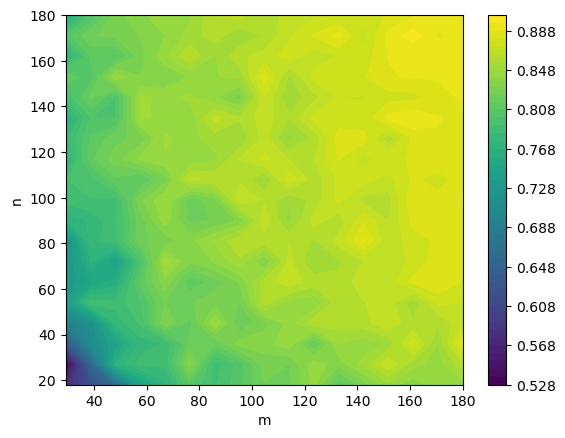

In [34]:
x

y = np.linspace(9,180,20)

y

xx,yy=np.meshgrid(x,y)

xx[1:,1:].shape

level = 1

plt.contourf(xx[level:,level:],yy[level:,level:],R2_a[level:,level:,0],origin='lower',levels=50)
plt.ylabel('n')
plt.xlabel('m')
plt.colorbar()

# Emulator

In [ ]:
y_train = torch.tensor(y_all.values[0:200])
x_train = torch.tensor(X_all.values[0:200])

In [ ]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

In [ ]:
y_train[100]

In [ ]:
nDim = X_all.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(X_all.iloc[:,i]),np.max(X_all.iloc[:,i])])
    print(boundsMaxMin[i])

In [ ]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [ ]:
import emcee
ndim = nDim
nwalkers = 18
p0 = np.random.multivariate_normal(centre, 0.000000001*np.identity(ndim), size=(nwalkers))
y_val = y_train[100]

In [ ]:
boundsMaxMin

In [ ]:
np.array(boundsMaxMin)[:,0]*2

In [ ]:
p0[0]

In [ ]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]*0.5<theta).all() and (theta<np.array(boundsMaxMin)[:,1]*2).all():
        return 0.0
    return -np.inf

In [ ]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        return 0.0
    return -np.inf

In [ ]:
x=torch.tensor(p0[0])[None]
ll =np.sum(emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],torch.ones(9)*0.01).detach().numpy())

In [ ]:
def log_likelihood(x,emulator,y_val):
    x=torch.tensor(x)[None]
    ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],[0.01,0.01,0.01,0.01,0.01,0.01,0.01,1e-6,0.01])).detach().numpy())
    return ll

In [ ]:
log_likelihood(p0[1],emulator,y_val)

In [ ]:
def log_prob(theta, emulator,y_val):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(theta,emulator, y_val)

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [ ]:
p0[i].shape

In [ ]:
torch.tensor(p0[0]).shape

In [ ]:
emulator.predict(torch.tensor(p0)).shape

In [ ]:
for i in range(16):
    print(log_prob(p0[i],emulator,y_val))

In [ ]:
import scipy

In [ ]:
def neg_log_likelihood(x,emulator,y_val):
    x=torch.tensor(x)[None]
    ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],[0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001])).detach().numpy())
    return -ll

In [ ]:
bds=np.array(boundsMaxMin)

In [ ]:
result = scipy.optimize.minimize(neg_log_likelihood, p0[0], args=(emulator,y_val), method='Nelder-Mead', tol=1e-8,bounds=bds)


In [ ]:
result

In [ ]:
result.x

In [ ]:
log_likelihood(p0[1],emulator,y_val)

In [ ]:
sampler.run_mcmc(p0, 80000)

In [ ]:
flat_samples = sampler.get_chain(discard=20000, thin=10, flat=True)
print(flat_samples.shape)

In [ ]:
y_val

In [ ]:
result.x

In [ ]:
x_train[100]

In [ ]:
import corner

fig = corner.corner(
    flat_samples, label_kwargs=dict(fontsize=18),color='orange',truths=result.x
);

In [ ]:
import corner

fig = corner.corner(
    flat_samples, label_kwargs=dict(fontsize=18),color='orange',truths=x_train[100]
);

In [ ]:
samp = pd.DataFrame(flat_samples).sample(50)

In [ ]:
samp.to_csv("MCMC_samples_scenario_6_80_2timesUpper.dat", sep = " ",index=False,header=None)

In [ ]:
flat_samples.mean(axis=0)

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [ ]:
x_out = torch.tensor(flat_samples.mean(axis=0).T)


In [ ]:
X_all.iloc[100]

In [ ]:
emulator.predict(x_out[None,:])

In [ ]:
x_all=torch.tensor(X_all.values)

In [ ]:
y_all=torch.tensor(y_all.values)


In [ ]:
y_test = y_all[45,:]
x_test = x_all[45,:]

y_train = y_all[~torch.all(y_all == y_test, dim=1)]
x_train = x_all[~torch.all(x_all == x_test, dim=1)]

In [ ]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_test])

In [ ]:
for i in range(16):
    print(log_prob(p0[i],emulator,y_val))

In [ ]:
sampler.run_mcmc(p0, 40000)

In [ ]:
flat_samples = sampler.get_chain(discard=8000, thin=1, flat=True)
print(flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(
    flat_samples, label_kwargs=dict(fontsize=18),color='orange',truths=y_test
);